<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#General-Information" data-toc-modified-id="General-Information-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>General Information</a></span><ul class="toc-item"><li><span><a href="#Difference-from-&quot;scannet&quot;-example" data-toc-modified-id="Difference-from-&quot;scannet&quot;-example-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Difference from "scannet" example</a></span></li></ul></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Experiment-environment-/-system-metrics" data-toc-modified-id="Experiment-environment-/-system-metrics-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Experiment environment / system metrics</a></span></li><li><span><a href="#Notebook-options" data-toc-modified-id="Notebook-options-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Notebook options</a></span></li><li><span><a href="#Source" data-toc-modified-id="Source-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Source</a></span><ul class="toc-item"><li><span><a href="#Train-/-Valid-/-Test-lists" data-toc-modified-id="Train-/-Valid-/-Test-lists-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Train / Valid / Test lists</a></span></li></ul></li><li><span><a href="#DataSets-config" data-toc-modified-id="DataSets-config-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>DataSets config</a></span></li><li><span><a href="#Datasets" data-toc-modified-id="Datasets-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Datasets</a></span></li><li><span><a href="#Transforms" data-toc-modified-id="Transforms-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Transforms</a></span><ul class="toc-item"><li><span><a href="#Define-Label-remaping" data-toc-modified-id="Define-Label-remaping-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Define Label remaping</a></span></li><li><span><a href="#Define-transforms" data-toc-modified-id="Define-transforms-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Define transforms</a></span></li><li><span><a href="#Apply-transforms" data-toc-modified-id="Apply-transforms-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Apply transforms</a></span></li></ul></li><li><span><a href="#DataBunch" data-toc-modified-id="DataBunch-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>DataBunch</a></span><ul class="toc-item"><li><span><a href="#Dataloader-idle-run-speed-measurement" data-toc-modified-id="Dataloader-idle-run-speed-measurement-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Dataloader idle run speed measurement</a></span></li></ul></li><li><span><a href="#Model" data-toc-modified-id="Model-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Model</a></span><ul class="toc-item"><li><span><a href="#learner-creation" data-toc-modified-id="learner-creation-10.1"><span class="toc-item-num">10.1&nbsp;&nbsp;</span>learner creation</a></span></li><li><span><a href="#Learning-Rate-finder" data-toc-modified-id="Learning-Rate-finder-10.2"><span class="toc-item-num">10.2&nbsp;&nbsp;</span>Learning Rate finder</a></span></li></ul></li><li><span><a href="#Train" data-toc-modified-id="Train-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Results</a></span></li></ul></div>

# General Information

This notebook demonstrates how the `fastai_sparse` library can be used in semantic segmentation tasks using the example of the [ScanNet](http://www.scan-net.org/) 3D semantic segmentation solution presented in [SparseConvNet example](https://github.com/facebookresearch/SparseConvNet/tree/master/examples/ScanNet). 


<img src="http://www.scan-net.org/img/scannet_benchmark.jpg" width="800" />

Initial data are indoor scenes with RGB and 3D-geometric information obtained as a result of three-dimensional scanning (100...500K vertices in ~1500 internal scenes). Format: 3D geometry mesh in format PLY.
The purpose - to predict a label of each vertices (20 furniture classes).

Evaluation metric: IoU (intersection over union)

Firstly, it is necessary to upload and prepare the initial data.  See [examples/scannet/data](https://github.com/goodok/fastai_sparse/tree/master/examples/scannet/data)


## Difference from "scannet" example


[examples/scannet/unet_normals_detailed.ipynb](https://nbviewer.jupyter.org/github/goodok/fastai_sparse/blob/master/examples/scannet/scannet_unet_detailed.ipynb)

1. To correctly calculate the normal values, spatial transformations are applied to the mesh, and only then, when converting the mesh to points cloud, they are calculated.
2. Batch size changed from 32 to 20
3. The model has been changed.:
 - size  of input features changed from 3 (colors) to 6 (normals + colors)
 - Linear layers and residue link are added to the top of the model.

Characteristics:
- Calculating normal values increases dataloader idle time by 90%. (from 1:51 to 3:30)
- time of the epoch has increased by 60%. (from 3:50 to 6:00)


In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# Imports

In [2]:
import os, sys
import time
import numpy as np
import pandas as pd
import glob
from os.path import join, exists, basename, splitext
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib import cm
import shutil
from functools import partial
from tqdm import tqdm
from joblib import Parallel, delayed, cpu_count
from IPython.display import display, HTML, FileLink

import torch
import torch.nn as nn
import torch.optim as optim

import sparseconvnet as scn

from fastai_sparse import utils, visualize
from fastai_sparse.utils import log
from fastai_sparse.data import SparseDataBunch
from fastai_sparse.datasets import DataSourceConfig, MeshesDataset
from fastai_sparse.learner import SparseModelConfig, Learner
from fastai_sparse.callbacks import TimeLogger, SaveModelCallback, CSVLogger

# autoreload python modules on the fly when its source is changed
%load_ext autoreload
%autoreload 2

Importing modules specific to this task (standard 3D semantic markers, ScanNet)

In [3]:
from fastai_sparse.metrics import IouMean
from metrics import IouMeanFiltred
from callbacks import CSVLoggerIouByClass

from data import merge_fn
import transforms as T

# Experiment environment / system metrics

In [4]:
experiment_name = 'scannet_unet_detailed'

In [5]:
utils.watermark(pandas=True)

virtualenv:     (fastai_sparse) 
python:         3.6.8
nvidia driver:  b'384.130'
nvidia cuda:    9.0, V9.0.176
cudnn:          7.1.4
torch:          1.0.1.post2
pandas:         0.24.2
fastai:         1.0.48
fastai_sparse:  0.0.4.dev0


In [6]:
#!git log1 -n3

In [7]:
# TODO: write to file versions, and so on
fn_commit = Path('results', experiment_name, 'commit.txt')
fn_commit.parent.mkdir(parents=True, exist_ok=True)
!git log -n1 --stat > {str(fn_commit)}

# Notebook options

In [8]:
utils.wide_notebook()
# uncomment this lines if you want switch off interactive and save visaulisation as screenshoots:
# For rendering run command in terminal:    `chromium-browser --remote-debugging-port=9222`
if  True:
    visualize.options.interactive = False
    visualize.options.save_images = True
    visualize.options.verbose = True
    visualize.options.filename_pattern_image = Path('images', experiment_name, 'fig_{fig_number}')

# Source

In [9]:
SOURCE_DIR = Path('data', 'scannet_merged_ply')
assert SOURCE_DIR.exists(), "Download data and run prepare_data.ipynb"

definition_of_spliting_dir = Path('data', 'ScanNet_Tasks_Benchmark')
assert definition_of_spliting_dir.exists()


os.listdir(SOURCE_DIR / 'scene0000_01')

['scene0000_01.merged.ply']

## Train / Valid / Test lists

MeshesDataset uses the pandas DataFrame as a datasource to determine the splitting into testing/valid as well as files locations.

In [10]:
def find_files(path, ext='merged.ply'):
    pattern = str(path / '*' / ('*' + ext))
    fnames = glob.glob(pattern)
    return fnames

def get_df_list(verbose=0):
    # train /valid / test splits
    fn_lists = {}

    fn_lists['train'] = definition_of_spliting_dir / 'scannetv1_train.txt'
    fn_lists['valid'] = definition_of_spliting_dir / 'scannetv1_val.txt'
    fn_lists['test'] = definition_of_spliting_dir / 'scannetv1_test.txt'

    for datatype in ['train', 'valid', 'test']:
        assert fn_lists[datatype].exists(), datatype

    dfs = {}
    total = 0
    for datatype in ['train', 'valid', 'test']:
        df = pd.read_csv(fn_lists[datatype], header=None, names=['example_id'])
        df = df.assign(datatype=datatype)
        df = df.assign(subdir=df.example_id)
        df = df.sort_values('example_id')
        dfs[datatype] = df

        if verbose:
            print(f"{datatype:5} counts: {len(df):>4}")
        
        total += len(df)
    if verbose:
        print(f"total:     {total}")
    return dfs

In [11]:
df_list = get_df_list(verbose=1)

train counts: 1045
valid counts:  156
test  counts:  312
total:     1513


# DataSets config
You can create MeshDataset using the configuration.

In [12]:
train_source_config = DataSourceConfig(root_dir=SOURCE_DIR,
                                       df=df_list['train'],
                                       batch_size=20,
                                       num_workers=8,
                                       ply_label_name='label',
                                       file_ext='.merged.ply',
                                      )

valid_source_config = DataSourceConfig(root_dir=SOURCE_DIR,
                                       df=df_list['valid'],
                                       batch_size=2,
                                       num_workers=2,
                                       ply_label_name='label',
                                       file_ext='.merged.ply',
                                       #init_numpy_random_seed=False,
                                      )

# Datasets

In [13]:
train_items = MeshesDataset.from_source_config(train_source_config)
valid_items = MeshesDataset.from_source_config(valid_source_config)

train_items.check()
valid_items.check()

Check files exist: 100%|██████████| 156/156 [00:00<00:00, 65163.97it/s]


Let's see what we've done with one example. 

In interactive mode, you can switch the color parameters (labels, rgb) to display labels or scan colors.

MeshItem (scene0000_00.merged.ply)
vertices:                shape: (81369, 3)            dtype: float64        min:   -0.01657,  max:    8.74040,  mean:    3.19051
faces:                   shape: (153587, 3)           dtype: int64          min:          0,  max:      81368,  mean: 40549.68796
colors:                  shape: (81369, 4)            dtype: uint8          min:    1.00000,  max:  255.00000,  mean:  145.80430
labels:                  shape: (81369,)              dtype: uint16         min:    0.00000,  max:  230.00000,  mean:   12.97057
Colors from vertices
Labels from vertices


/media/Linux_3Tb/p/fastai_sparse.alex/examples/scannet_normals/images/scannet_unet_detailed/fig_1.png

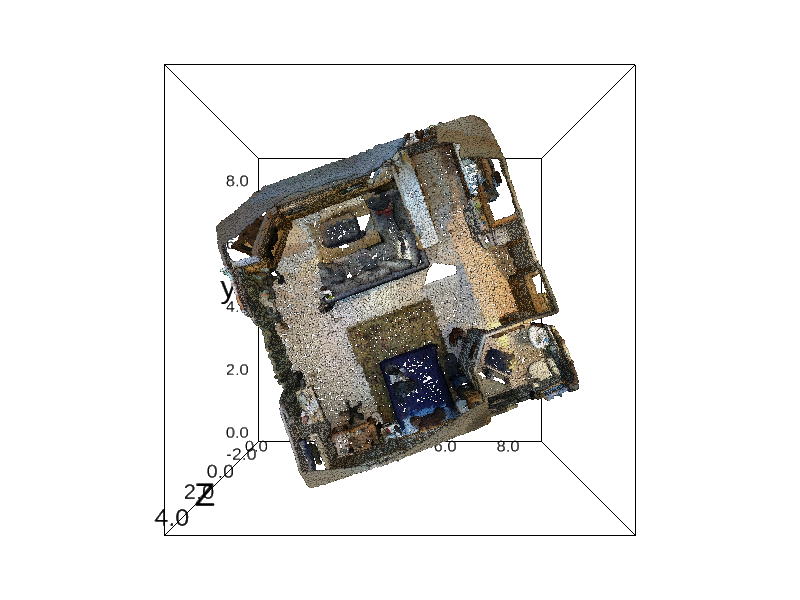

In [14]:
o = train_items[0]
o.describe()
o.show()

# Transforms

## Define Label remaping

In [15]:
df_classes = pd.read_csv(definition_of_spliting_dir / 'classes_SemVoxLabel-nyu40id.txt', header=None, names=['class_id', 'name'], delim_whitespace=True)
# Map relevant classes to {0,1,...,19}, and ignored classes to -100
remapper = np.ones(3000, dtype=np.int32) * (-100)
for i, x in enumerate([1,2,3,4,5,6,7,8,9,10,11,12,14,16,24,28,33,34,36,39]):
    remapper[x] = i

## Define transforms

In order to reproduce the [example of SparseConvNet](https://github.com/facebookresearch/SparseConvNet/tree/master/examples/ScanNet), the same transformations have been redone, but in the manner of fast.ai transformations.

The following cells define the transformations: preprocessing (PRE_TFMS); augmentation (AUGS_); and transformation to convert the points cloud to a sparse representation (SPARSE_TFMS). Sparse  representation is the input format for the SparseConvNet model and contains a list of voxels and their features

In [16]:
PRE_TFMS = [
            T.remap_labels(remapper=remapper),
            T.colors_normalize(),
            T.normalize_spatial(),
           ]

_scale = 20

AUGS_TRAIN = [
    T.noise_affine(amplitude=0.1),
    T.flip_x(p=0.5),
    T.scale(scale=_scale),
    T.rotate_XY(),
    
    T.elastic(gran=6 * _scale // 50, mag=40 * _scale / 50),
    T.elastic(gran=20 * _scale // 50, mag=160 * _scale / 50),
    
    T.specific_translate(full_scale=4096),
    T.to_points_cloud(method='vertices', normals=True), 
    
    T.crop_points(low=0, high=4096),
    T.colors_noise(amplitude=0.1),
]

AUGS_VALID = [
    T.noise_affine(amplitude=0.1),
    T.flip_x(p=0.5),
    T.scale(scale=_scale),
    T.rotate_XY(),

    T.translate(offset=4096 / 2),
    T.rand_translate(offset=(-2, 2, 3)),  # low, high, dimention
    
    T.specific_translate(full_scale=4096),

    T.to_points_cloud(method='vertices', normals=True), 
    T.crop_points(low=0, high=4096),
    T.colors_noise(amplitude=0.1),
        
    ]

SPARSE_TFMS = [
    T.merge_features(ones=False, colors=True, normals=True),
    T.to_sparse_voxels(),
]

# train/valid transforms
tfms = (
    PRE_TFMS + AUGS_TRAIN + SPARSE_TFMS,
    PRE_TFMS + AUGS_VALID + SPARSE_TFMS,
)

## Apply transforms
Now we will apply the transformation to the data sets.

In [17]:
train_items.transform(tfms[0])
pass

valid_items.transform(tfms[1])
pass

# DataBunch

In fast.ai the data is represented DataBunch which contains train, valid and optionally test data loaders.

In [18]:
data = SparseDataBunch.create(train_ds=train_items,
                              valid_ds=valid_items,
                              collate_fn=merge_fn)

In [19]:
data.describe()

Train:  1045, shuffle:  True, batch_size: 20, num_workers:  8, num_batches: 52, drop_last: True
Valid:   156, shuffle: False, batch_size:  2, num_workers:  2, num_batches: 78, drop_last: False


## Dataloader idle run speed measurement

In [20]:
print("cpu_count:", cpu_count())
!lscpu | grep "Model"

cpu_count: 16
Model name:            AMD Ryzen 7 1700 Eight-Core Processor


In [21]:
# train
t = tqdm(enumerate(data.train_dl), total=len(data.train_dl))
for i, batch in t:
    pass

100%|██████████| 52/52 [03:33<00:00,  4.11s/it]


In [22]:
# valid
t = tqdm(enumerate(data.valid_dl), total=len(data.valid_dl))
for i, batch in t:
    pass

100%|██████████| 78/78 [00:30<00:00,  2.59it/s]


# Model
U-Net SparseConvNet implemenation ([link](https://github.com/facebookresearch/SparseConvNet/blob/master/examples/ScanNet/unet.py)): 

In [20]:
# spatial_size  is full_scale
model_config = SparseModelConfig(spatial_size=4096, num_classes=20, num_input_features=6, mode=4, downsample=[2, 2],
                                 m=16, num_planes_coeffs=[1, 2, 3, 4, 5, 6],
                                 block_reps=2)

In [21]:
class Model(nn.Module):
    def __init__(self, cfg):
        C = cfg
        nn.Module.__init__(self)
        self.sparseModel = scn.Sequential(
            scn.InputLayer(C.dimension, C.spatial_size, mode=C.mode),
            scn.SubmanifoldConvolution(C.dimension, nIn=C.num_input_features, nOut=C.m, filter_size=3, bias=C.bias),
            scn.UNet(C.dimension, C.block_reps, C.num_planes, residual_blocks=C.residual_blocks, downsample=C.downsample),
            scn.BatchNormReLU(C.m),
            scn.OutputLayer(C.dimension),
        )
        #self.linear = nn.Linear(cfg.m, cfg.num_classes)
        self.linear1 = nn.Sequential(
            nn.Linear(C.m + 3, C.m * 2),
            nn.BatchNorm1d(C.m * 2),
            nn.ReLU(),            
        )
        self.linear2 = nn.Sequential(
            nn.Linear(C.m * 2, C.m * 2),
            nn.BatchNorm1d(C.m * 2),
            nn.ReLU(),            
        )
        self.linear3 = nn.Sequential(            
            nn.Linear(C.m * 2, C.num_classes),
        )

    def forward(self, xb):
        x = [xb['coords'], xb['features']]
        
        normals = xb['features'][:, 0:3]
        
        x = self.sparseModel(x)

        x = torch.cat([x, normals], dim=1)

        x = self.linear1(x)
        
        # residual
        x = x + self.linear2(x)
        
        x = self.linear3(x)
        return x

model = Model(model_config)

## learner creation
Learner is core fast.ai class which contains model architecture, databunch and optimizer options and implement train loop and prediction

In [22]:
learn = Learner(data, model,
                opt_func=partial(optim.Adam),
                path=str(Path('results', experiment_name)))

## Learning Rate finder
We use Learning Rate Finder provided by fast.ai library to find the optimal learning rate

In [26]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


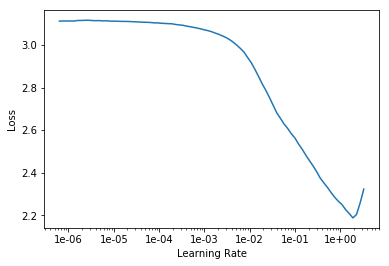

In [27]:
learn.recorder.plot()

# Train
To visualize the learning process, we specify some additional callbacks 

In [23]:
learn.callbacks = []
cb_iouf = IouMeanFiltred(learn, model_config.num_classes)
learn.callbacks.append(cb_iouf)
learn.callbacks.append(TimeLogger(learn))

learn.callbacks.append(CSVLogger(learn))
learn.callbacks.append(CSVLoggerIouByClass(learn, cb_iouf, class_names=list(df_classes.name), filename='iouf_by_class'))
learn.callbacks.append(SaveModelCallback(learn, every='epoch', name='weights', overwrite=True))

In [24]:
learn.fit(10)

epoch,train_loss,valid_loss,train_time,valid_time,train_iouf,valid_iouf,time
0,1.404268,0.978971,327.169233,37.543263,0.077395,0.093291,06:04
1,1.093948,0.964796,324.174373,37.640192,0.091051,0.093519,06:01
2,0.986519,0.870876,322.743496,38.270623,0.099397,0.108651,06:01
3,0.925569,0.809824,326.083905,37.536581,0.105515,0.112858,06:03
4,0.891360,0.786342,322.909716,37.633485,0.109948,0.118070,06:00
5,0.863138,0.802229,325.130574,36.996391,0.125878,0.131315,06:02
6,0.849502,0.774441,324.841139,37.981914,0.138563,0.151800,06:02
7,0.823132,0.715294,324.287426,37.563040,0.146411,0.164481,06:01
8,0.810195,0.743928,325.731297,37.968276,0.153460,0.168483,06:03
9,0.796525,0.703750,327.882359,38.373070,0.155414,0.176049,06:06


/media/Linux_3Tb/p/fastai_sparse.alex/examples/scannet_normals/metrics.py:112: UserWarning: Wrong example is found: all `labels_raw` < 0. Id=scene0509_00
  warnings.warn(f"Wrong example is found: all `labels_raw` < 0. Id={xb['ids'][k]}")


In [ ]:
learn.fit(512)

# Results

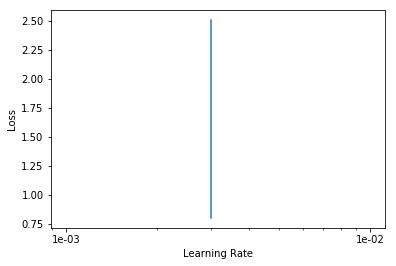

In [25]:
learn.recorder.plot()

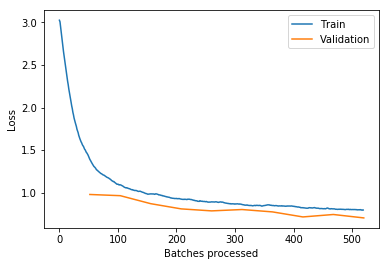

In [26]:
learn.recorder.plot_losses()

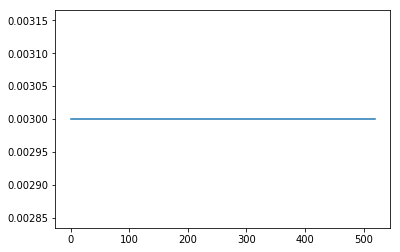

In [27]:
learn.recorder.plot_lr()

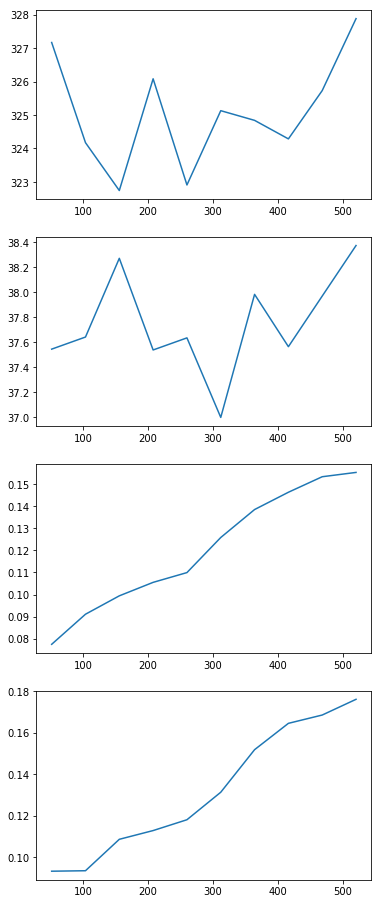

In [28]:
learn.recorder.plot_metrics()

In [29]:
cb = learn.find_callback(CSVLoggerIouByClass)
cb.read_logged_file().iloc[-1:].T

,19
epoch,9
datatype,valid
mean_iou,0.176049
wall,0.791966
floor,0.424182
cabinet,0.94113
bed,0.377506
chair,0
sofa,0.271041
table,3.8e-05
